## Libraries

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Getting Data and Preprocessing

In [75]:
#ARRANGE BTC PRICE DATAFRAME

df = pd.read_csv("BTC_historical_data_last.csv")
#drop 2021 data
n_tail = 32
n_head = 1188
df.drop(df.tail(n_tail).index,inplace=True)
df.drop(df.head(n_head).index,inplace=True)
df.head(10)

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
1188,BTC,2017-01-01,964.32500,952.45500,968.48500,949.08625
1189,BTC,2017-01-02,1009.97375,964.32500,1011.52500,963.53000
1190,BTC,2017-01-03,1028.33375,1009.97375,1034.10500,998.62125
1191,BTC,2017-01-04,1047.09999,1028.33375,1048.12375,1013.37750
1192,BTC,2017-01-05,1140.38500,1047.09999,1141.99750,1047.06375
1193,BTC,2017-01-06,985.93875,1140.38500,1153.02000,887.46625
1194,BTC,2017-01-07,837.83625,985.93875,990.37125,821.65500
1195,BTC,2017-01-08,923.52375,837.83625,923.74750,816.36375
1196,BTC,2017-01-09,889.33875,923.52375,942.06250,878.10125
1197,BTC,2017-01-10,905.22625,889.33875,911.99625,881.15750


In [76]:
weekly_price_list = []
closing_prices = list(df['Closing Price (USD)'])

temp_list = []
for i in range(0,len(closing_prices)):
    if (i + 1) % 7 == 0:
        temp_list.append(closing_prices[i])
        weekly_price_list.append(temp_list)
        temp_list = []
    else:
        temp_list.append(closing_prices[i])
        
    
mean_weekly_list = []    
for i in weekly_price_list:
    mean_weekly_list.append(np.mean(i))
    
#len(mean_weekly_list)
mean_weekly_list

[1001.9846414285714,
 858.1341071428571,
 870.8037499999999,
 914.2276785714286,
 963.7555357142858,
 1027.1746414285715,
 1017.6185714285714,
 1112.9139271428571,
 1212.71057,
 1217.4027114285714,
 1192.346425714286,
 1023.576712857143,
 1020.8408542857143,
 1147.8891428571428,
 1203.426282857143,
 1221.29832,
 1277.5333928571429,
 1447.7299985714287,
 1659.5298214285715,
 1803.6194642857142,
 2287.143032857143,
 2324.5616042857146,
 2756.7523214285716,
 2696.0798199999995,
 2710.0449985714286,
 2559.4280314285716,
 2559.18375,
 2377.136248571428,
 2343.620891428571,
 2700.3805342857145,
 2816.55375,
 3420.284107142857,
 4219.528035714286,
 4179.868748571429,
 4593.250714285715,
 4485.219464285715,
 3955.7485699999997,
 3763.3749999999995,
 3982.4425,
 4332.706427142857,
 4979.380354285714,
 5705.200535714285,
 5793.775000000001,
 6533.885357142857,
 7208.051607142858,
 6908.555535714286,
 8037.998035714286,
 9943.708392857143,
 13150.484285714285,
 16201.342677142855,
 17065.23499714

In [77]:
trends_weekly_df = pd.read_csv("weekly_chart_google_trends.csv")
trends_weekly_df.columns = trends_weekly_df.iloc[0]
# trends_weekly_df = trends_weekly_df[47:256]
trends_weekly_df = trends_weekly_df[50:256]
trends_weekly_df['Bitcoin: (Dünya Genelinde)'] = trends_weekly_df['Bitcoin: (Dünya Genelinde)'].astype("int")
trends_weekly_df

Hafta,Bitcoin: (Dünya Genelinde)
2017-01-22,5
2017-01-29,5
2017-02-05,5
2017-02-12,5
2017-02-19,5
...,...
2020-11-29,22
2020-12-06,18
2020-12-13,28
2020-12-20,29


In [78]:
trends_weekly_df['Mean Prices'] = np.array(mean_weekly_list)
trends_weekly_df

Hafta,Bitcoin: (Dünya Genelinde),Mean Prices
2017-01-22,5,1001.984641
2017-01-29,5,858.134107
2017-02-05,5,870.803750
2017-02-12,5,914.227679
2017-02-19,5,963.755536
...,...,...
2020-11-29,22,18448.450613
2020-12-06,18,18178.690735
2020-12-13,28,19058.795087
2020-12-20,29,18811.005779


In [79]:
# Check null values
trends_weekly_df.isnull().sum()

Hafta
Bitcoin: (Dünya Genelinde)    0
Mean Prices                   0
dtype: int64

Text(0.5, 1.0, 'Google Trends Data')

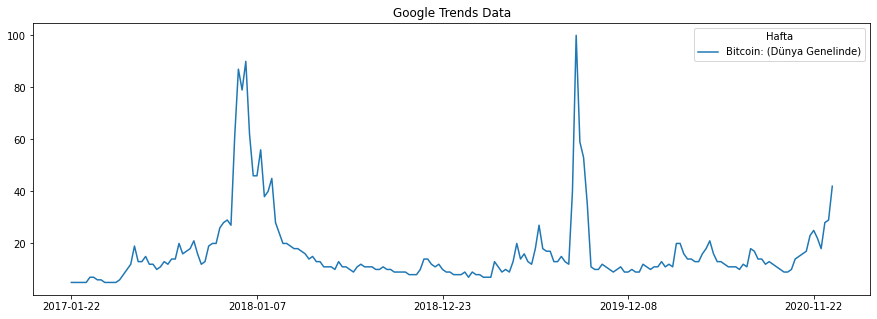

In [80]:
trends_weekly_df[['Bitcoin: (Dünya Genelinde)']].plot(figsize=(15, 5))
plt.title("Google Trends Data")

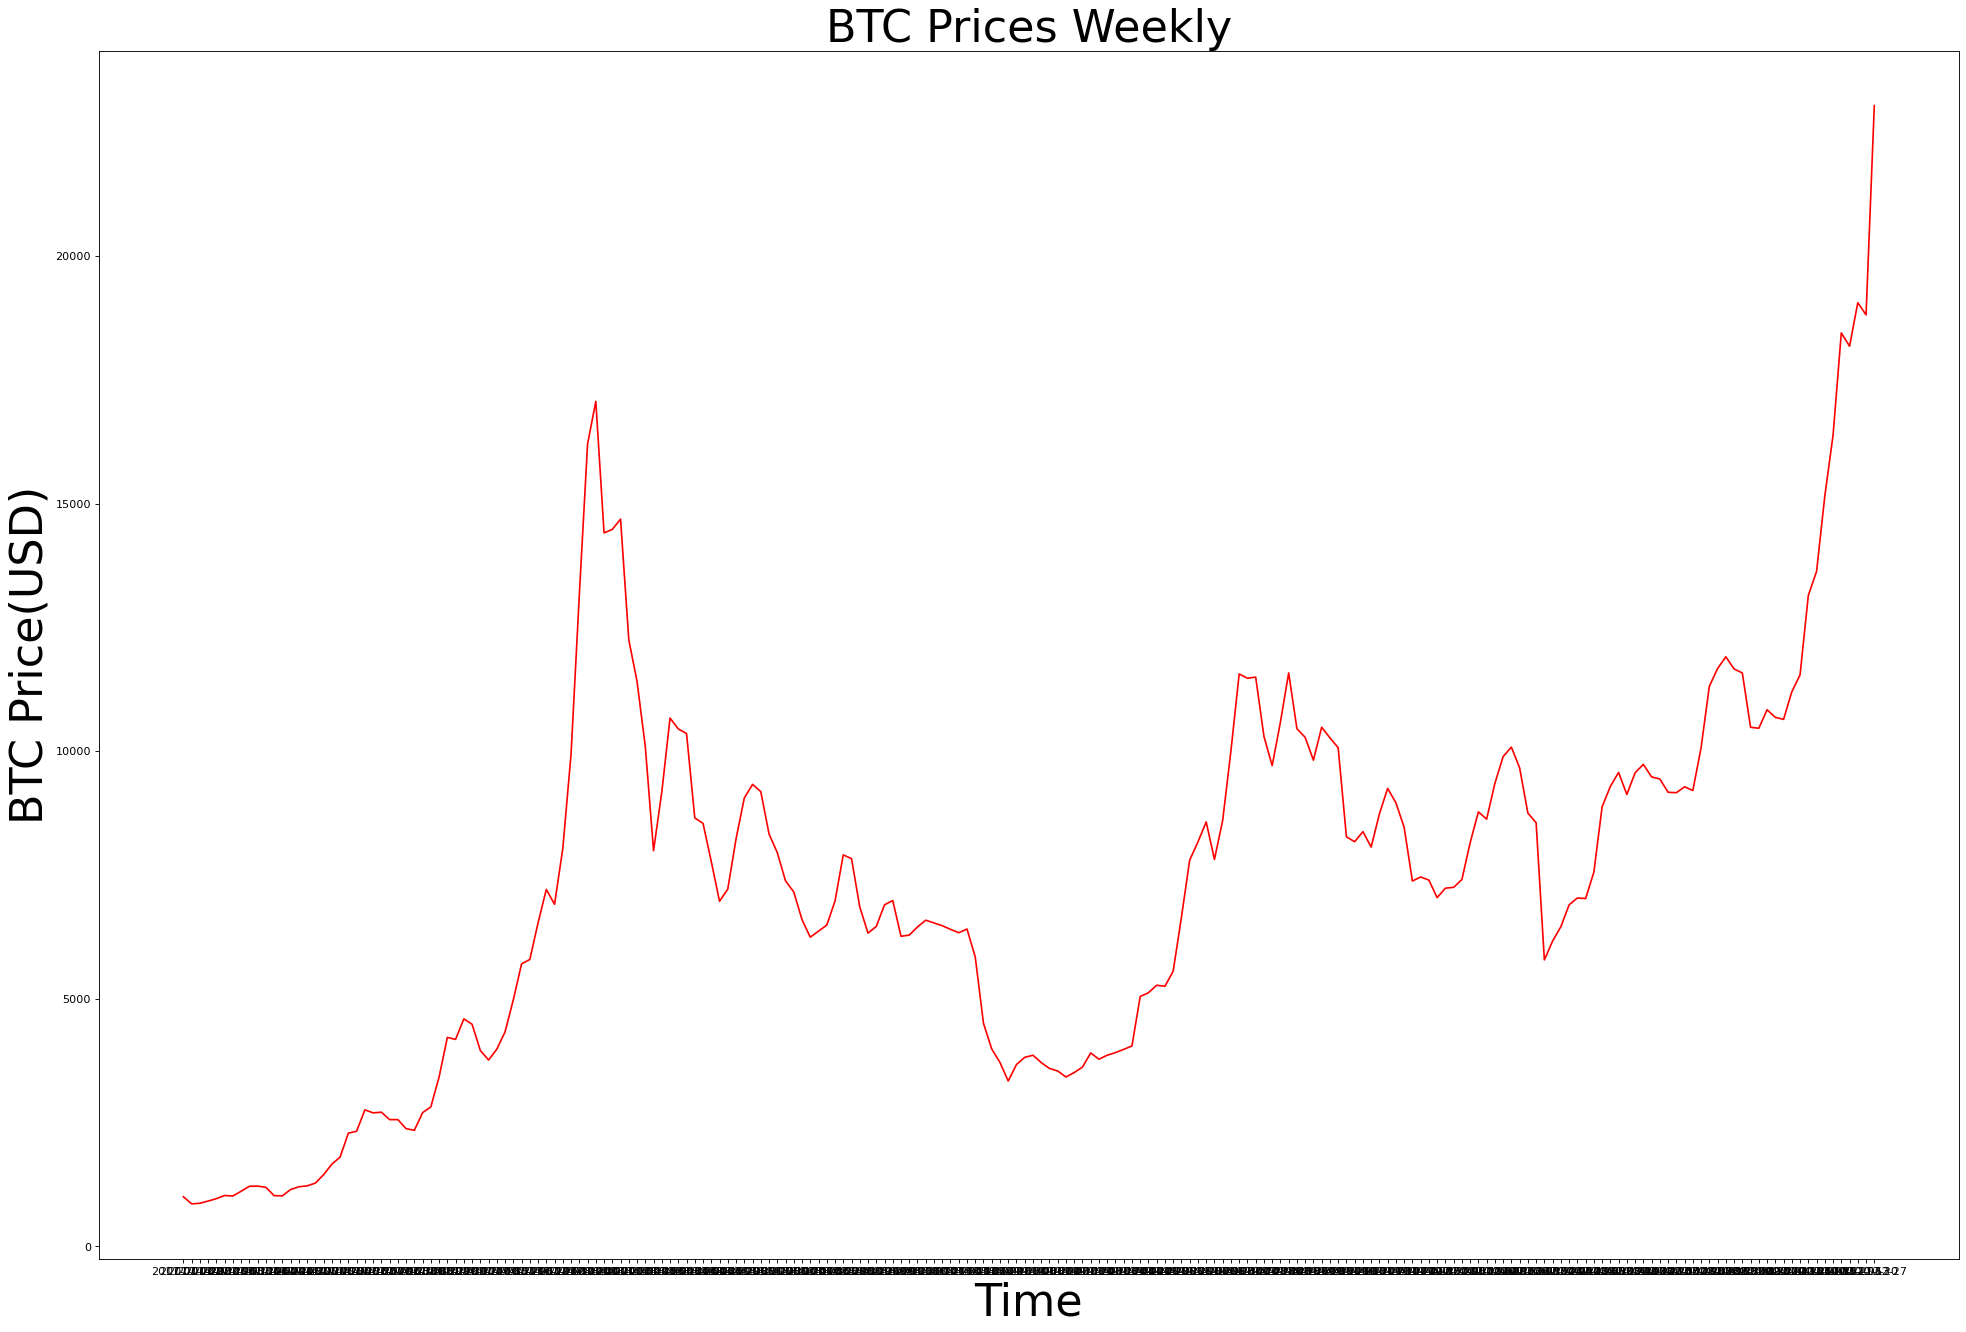

In [81]:
# The Prices of Bitcoin over time
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(trends_weekly_df['Mean Prices'], color='red', label='Real BTC Price')
plt.title('BTC Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.show()

In [82]:
trends_weekly_df['Hafta Feature'] = trends_weekly_df.index
trends_weekly_df

Hafta,Bitcoin: (Dünya Genelinde),Mean Prices,Hafta Feature
2017-01-22,5,1001.984641,2017-01-22
2017-01-29,5,858.134107,2017-01-29
2017-02-05,5,870.803750,2017-02-05
2017-02-12,5,914.227679,2017-02-12
2017-02-19,5,963.755536,2017-02-19
...,...,...,...
2020-11-29,22,18448.450613,2020-11-29
2020-12-06,18,18178.690735,2020-12-06
2020-12-13,28,19058.795087,2020-12-13
2020-12-20,29,18811.005779,2020-12-20


In [83]:
cols = list(trends_weekly_df)[0:3]

In [84]:
# Converting dates as a datetime object
datelist_train = list(trends_weekly_df['Hafta Feature'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
trends_weekly_df.index = datelist_train
trends_weekly_df

Hafta,Bitcoin: (Dünya Genelinde),Mean Prices,Hafta Feature
2017-01-22,5,1001.984641,2017-01-22
2017-01-29,5,858.134107,2017-01-29
2017-02-05,5,870.803750,2017-02-05
2017-02-12,5,914.227679,2017-02-12
2017-02-19,5,963.755536,2017-02-19
...,...,...,...
2020-11-29,22,18448.450613,2020-11-29
2020-12-06,18,18178.690735,2020-12-06
2020-12-13,28,19058.795087,2020-12-13
2020-12-20,29,18811.005779,2020-12-20


## Shifting Data to the right

In [85]:
trends_weekly_df['Shifted Mean Prices'] = trends_weekly_df['Mean Prices'].shift(1, axis = 0) 
trends_weekly_df['Trends Shifted'] = trends_weekly_df['Bitcoin: (Dünya Genelinde)'].shift(1, axis = 0)
trends_weekly_df = trends_weekly_df[1:]
trends_weekly_df

Hafta,Bitcoin: (Dünya Genelinde),Mean Prices,Hafta Feature,Shifted Mean Prices,Trends Shifted
2017-01-29,5,858.134107,2017-01-29,1001.984641,5.0
2017-02-05,5,870.803750,2017-02-05,858.134107,5.0
2017-02-12,5,914.227679,2017-02-12,870.803750,5.0
2017-02-19,5,963.755536,2017-02-19,914.227679,5.0
2017-02-26,7,1027.174641,2017-02-26,963.755536,5.0
...,...,...,...,...,...
2020-11-29,22,18448.450613,2020-11-29,16382.321856,25.0
2020-12-06,18,18178.690735,2020-12-06,18448.450613,22.0
2020-12-13,28,19058.795087,2020-12-13,18178.690735,18.0
2020-12-20,29,18811.005779,2020-12-20,19058.795087,28.0


## Correlation

In [86]:
trends_weekly_df.corr()

Hafta,Bitcoin: (Dünya Genelinde),Mean Prices,Shifted Mean Prices,Trends Shifted
Hafta,,,,
Bitcoin: (Dünya Genelinde),1.000000,0.391505,0.365550,0.854723
Mean Prices,0.391505,1.000000,0.979259,0.410756
Shifted Mean Prices,0.365550,0.979259,1.000000,0.378146
Trends Shifted,0.854723,0.410756,0.378146,1.000000


# Splitting the data to train and test based on the prediction day we want

In [87]:
date_string = "21 June, 2019"
#possible parameter %H:%M:%S
dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = trends_weekly_df.loc[trends_weekly_df.index <= dt_onject_split].copy()
data_test = trends_weekly_df.loc[trends_weekly_df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)

Data train shape (125, 5)
Data test shape (80, 5)


## Functions to create features based on train and test data

In [88]:
def create_features_with_shifted_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['month'] = df['Hafta'].dt.month
    df['year'] = df['Hafta'].dt.year
    df['dayofmonth'] = df['Hafta'].dt.day

    
    X = df[['month','year','dayofmonth','Trends Shifted','Shifted Mean Prices']]
    if label:
        y = df[label]
        return X, y
    return X


def create_features_with_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['month'] = df['Hafta'].dt.month
    df['year'] = df['Hafta'].dt.year
    df['dayofmonth'] = df['Hafta'].dt.day

    
    X = df[['month','year','dayofmonth','Bitcoin: (Dünya Genelinde)','Shifted Mean Prices']]
    if label:
        y = df[label]
        return X, y
    return X



def create_features_without_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['month'] = df['Hafta'].dt.month
    df['year'] = df['Hafta'].dt.year
    df['dayofmonth'] = df['Hafta'].dt.day

    
    X = df[['month','year','dayofmonth','Shifted Mean Prices']]
    if label:
        y = df[label]
        return X, y
    return X

## Create a train and test data. 

In [89]:
X_train, y_train = create_features_with_google_trends(data_train, label='Mean Prices')
X_test, y_test = create_features_with_google_trends(data_test, label='Mean Prices')

X_train['Bitcoin: (Dünya Genelinde)'] = X_train['Bitcoin: (Dünya Genelinde)'].astype(int)
X_test['Bitcoin: (Dünya Genelinde)'] = X_test['Bitcoin: (Dünya Genelinde)'].astype(int)



X_train_second, y_train_second = create_features_without_google_trends(data_train, label='Mean Prices')
X_test_second, y_test_second = create_features_without_google_trends(data_test, label='Mean Prices')



X_train_shifted_google, y_train_shifted_google = create_features_with_shifted_google_trends(data_train, label='Mean Prices')
X_test_shifted_google, y_test_shifted_google = create_features_with_shifted_google_trends(data_test, label='Mean Prices')

X_train_shifted_google['Trends Shifted'] = X_train_shifted_google['Trends Shifted'].astype(int)
X_test_shifted_google['Trends Shifted'] = X_test_shifted_google['Trends Shifted'].astype(int)

<ipython-input-89-4a0fd9a2b9e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Bitcoin: (Dünya Genelinde)'] = X_train['Bitcoin: (Dünya Genelinde)'].astype(int)
<ipython-input-89-4a0fd9a2b9e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Bitcoin: (Dünya Genelinde)'] = X_test['Bitcoin: (Dünya Genelinde)'].astype(int)
<ipython-input-89-4a0fd9a2b9e1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

## Create an LSTM model. 

In [90]:
min_max_scaler = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()

In [91]:
# Turning input X_Train to appropriate shape for LSTM    ((n_samples, time_steps, features))
x_training_set = X_train.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

y_train = pd.DataFrame(y_train)
list(y_train['Mean Prices'])
y_train_values = [float(i) for i in y_train['Mean Prices']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y.fit_transform(y_train_values)

In [92]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
25/25 [==============================] - 1s 781us/step - loss: 0.0954
Epoch 2/100
25/25 [==============================] - 0s 716us/step - loss: 0.0371
Epoch 3/100
25/25 [==============================] - 0s 790us/step - loss: 0.0415
Epoch 4/100
25/25 [==============================] - 0s 798us/step - loss: 0.0205
Epoch 5/100
25/25 [==============================] - 0s 693us/step - loss: 0.0213
Epoch 6/100
25/25 [==============================] - 0s 732us/step - loss: 0.0219
Epoch 7/100
25/25 [==============================] - 0s 762us/step - loss: 0.0188
Epoch 8/100
25/25 [==============================] - 0s 790us/step - loss: 0.0145
Epoch 9/100
25/25 [==============================] - 0s 744us/step - loss: 0.0107
Epoch 10/100
25/25 [==============================] - 0s 798us/step - loss: 0.0079
Epoch 11/100
25/25 [==============================] - 0s 708us/step - loss: 0.0081
Epoch 12/100
25/25 [==============================] - 0s 763us/step - loss: 0.0078
Epoch 13/100


25/25 [==============================] - 0s 728us/step - loss: 0.0015
Epoch 100/100
25/25 [==============================] - 0s 736us/step - loss: 0.0014


## Predicting the model with google trends as features

In [93]:
test_set = X_test.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 5))
inputs = min_max_scaler.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 5))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 5))
predicted_price = min_max_scaler_y.inverse_transform(predicted_price)

In [99]:
mae_google_trends = mean_absolute_error(y_test,predicted_price)
rmse_google_trends = mean_squared_error(y_test,predicted_price,squared=False)

print("Mean Absolute Error for features including google trends and shifted mean prices and date: ",mae_google_trends)
print("Root Mean Squared Error for features including google trends and shifted mean prices and date: ",rmse_google_trends)

Mean Absolute Error for features including google trends and shifted mean prices and date:  617.6004945163918
Root Mean Squared Error for features including google trends and shifted mean prices and date:  835.105946170023


In [95]:
# Predictions for these days are made
X_test.index

Index([2019-06-23, 2019-06-30, 2019-07-07, 2019-07-14, 2019-07-21, 2019-07-28,
       2019-08-04, 2019-08-11, 2019-08-18, 2019-08-25, 2019-09-01, 2019-09-08,
       2019-09-15, 2019-09-22, 2019-09-29, 2019-10-06, 2019-10-13, 2019-10-20,
       2019-10-27, 2019-11-03, 2019-11-10, 2019-11-17, 2019-11-24, 2019-12-01,
       2019-12-08, 2019-12-15, 2019-12-22, 2019-12-29, 2020-01-05, 2020-01-12,
       2020-01-19, 2020-01-26, 2020-02-02, 2020-02-09, 2020-02-16, 2020-02-23,
       2020-03-01, 2020-03-08, 2020-03-15, 2020-03-22, 2020-03-29, 2020-04-05,
       2020-04-12, 2020-04-19, 2020-04-26, 2020-05-03, 2020-05-10, 2020-05-17,
       2020-05-24, 2020-05-31, 2020-06-07, 2020-06-14, 2020-06-21, 2020-06-28,
       2020-07-05, 2020-07-12, 2020-07-19, 2020-07-26, 2020-08-02, 2020-08-09,
       2020-08-16, 2020-08-23, 2020-08-30, 2020-09-06, 2020-09-13, 2020-09-20,
       2020-09-27, 2020-10-04, 2020-10-11, 2020-10-18, 2020-10-25, 2020-11-01,
       2020-11-08, 2020-11-15, 2020-11-22, 2020-11-2

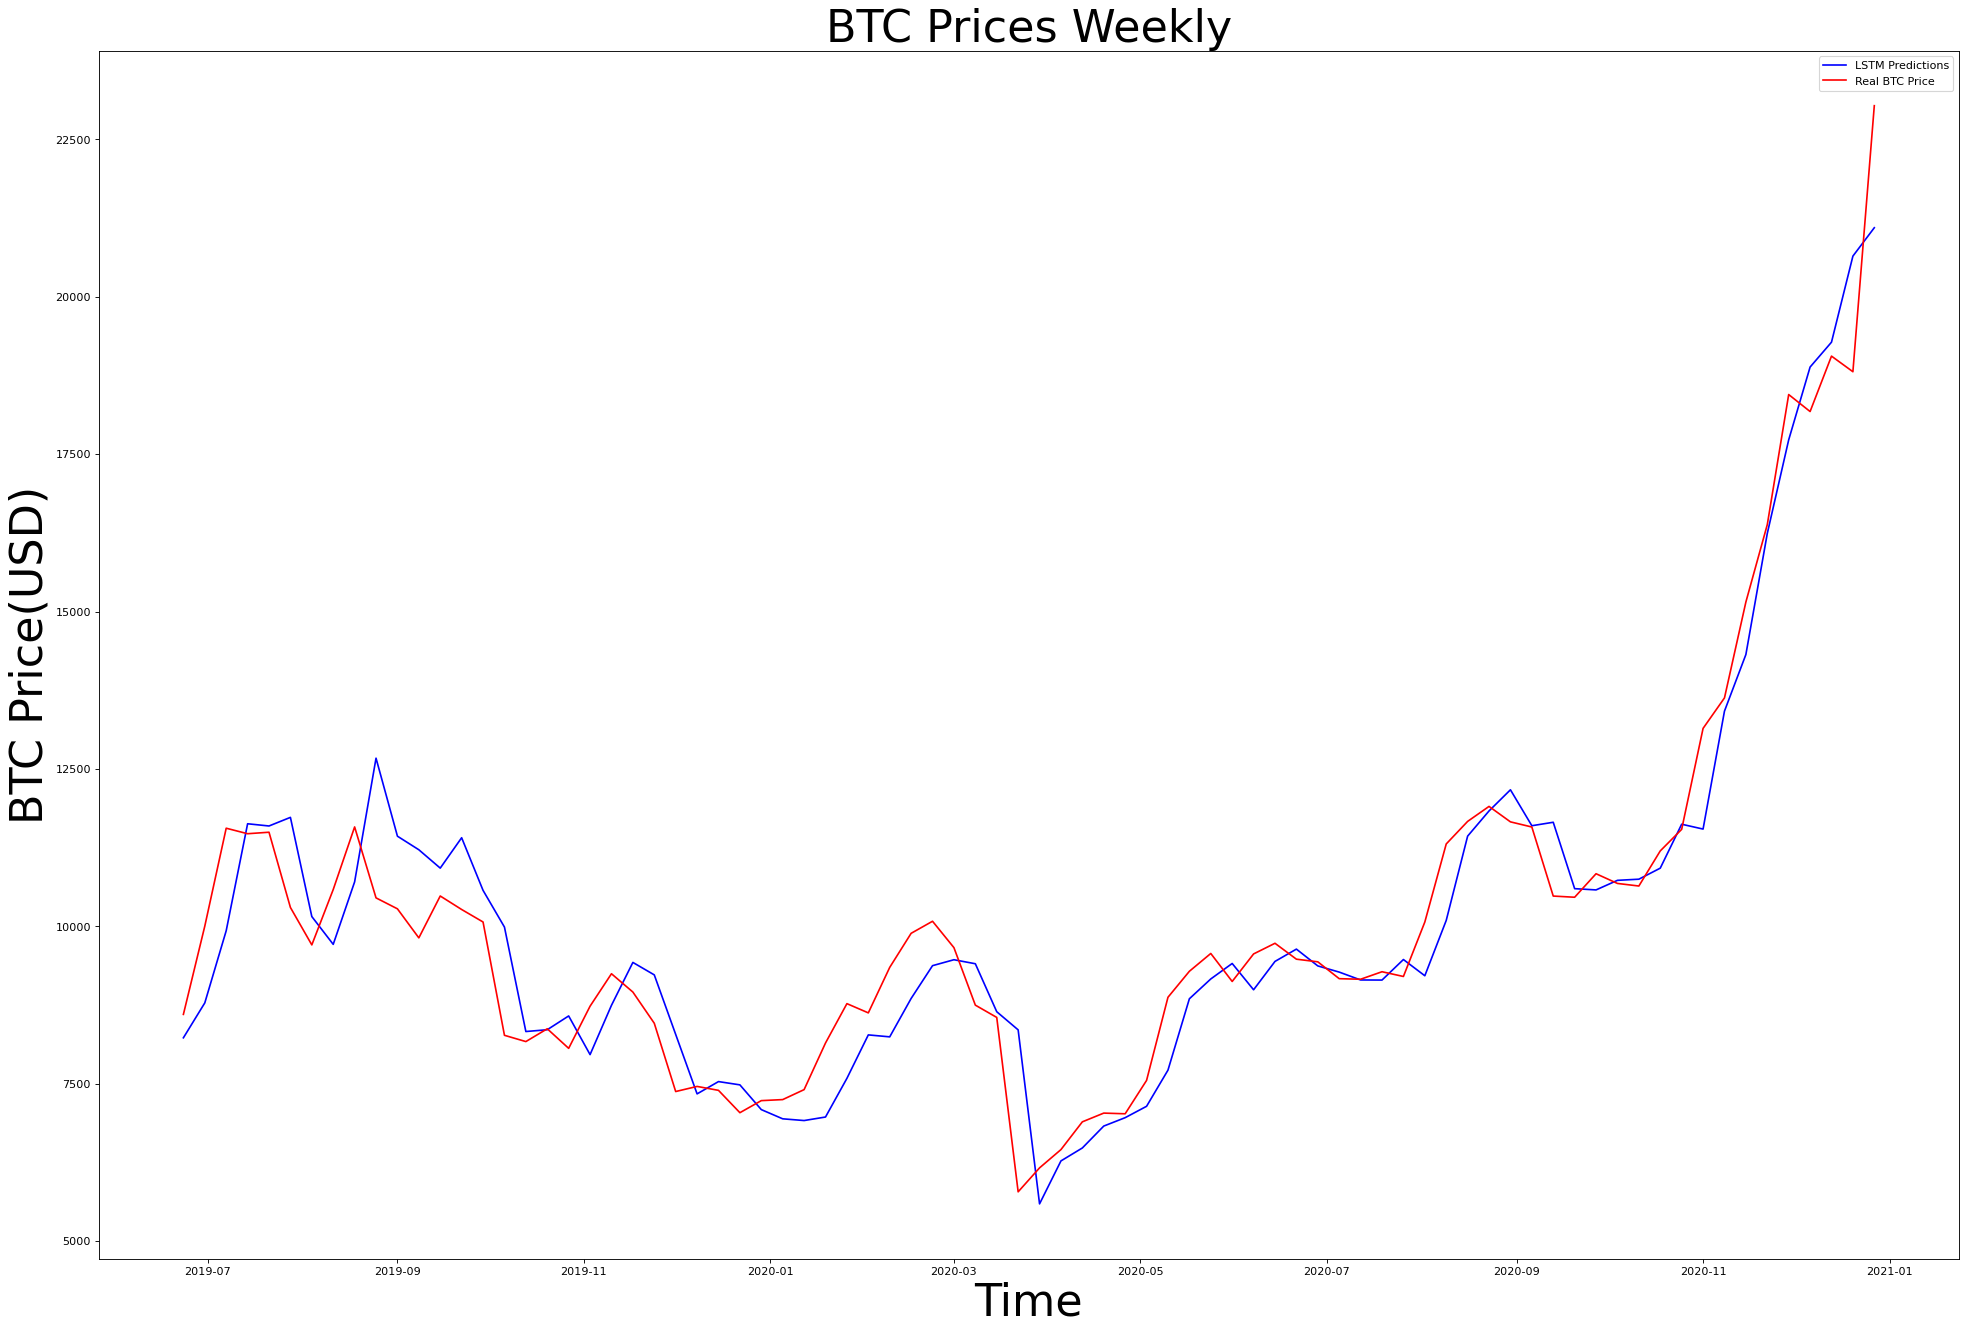

In [96]:
y_test_values = [float(i) for i in y_test]
# The Prices of Bitcoin over time
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test.index,y_test_values, color='red', label='Real BTC Price')
plt.title('BTC Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend()
plt.show()

## Predicting the model without google trends as features

In [101]:
min_max_scaler_second = MinMaxScaler()
min_max_scaler_y_second = MinMaxScaler()

In [102]:
# Turning input X_Train to appropriate shape for LSTM    ((n_samples, time_steps, features))
x_training_set = X_train_second.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler_second.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

y_train = pd.DataFrame(y_train_second)
list(y_train['Mean Prices'])
y_train_values = [float(i) for i in y_train['Mean Prices']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y_second.fit_transform(y_train_values)

In [103]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
25/25 [==============================] - 1s 747us/step - loss: 0.1230
Epoch 2/100
25/25 [==============================] - 0s 729us/step - loss: 0.0429
Epoch 3/100
25/25 [==============================] - 0s 774us/step - loss: 0.0394
Epoch 4/100
25/25 [==============================] - 0s 720us/step - loss: 0.0294
Epoch 5/100
25/25 [==============================] - 0s 735us/step - loss: 0.0196
Epoch 6/100
25/25 [==============================] - 0s 738us/step - loss: 0.0246
Epoch 7/100
25/25 [==============================] - 0s 714us/step - loss: 0.0184
Epoch 8/100
25/25 [==============================] - 0s 759us/step - loss: 0.0160
Epoch 9/100
25/25 [==============================] - 0s 706us/step - loss: 0.0168
Epoch 10/100
25/25 [==============================] - 0s 846us/step - loss: 0.0105
Epoch 11/100
25/25 [==============================] - 0s 732us/step - loss: 0.0113
Epoch 12/100
25/25 [==============================] - 0s 730us/step - loss: 0.0074
Epoch 13/100


25/25 [==============================] - 0s 742us/step - loss: 0.0017
Epoch 100/100
25/25 [==============================] - 0s 777us/step - loss: 0.0014


In [104]:
test_set = X_test_second.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 4))
inputs = min_max_scaler_second.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 4))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 4))
predicted_price = min_max_scaler_y_second.inverse_transform(predicted_price)

In [105]:
mae_google_trends = mean_absolute_error(y_test,predicted_price)
rmse_google_trends = mean_squared_error(y_test,predicted_price,squared=False)

print("Mean Absolute Error for features shifted mean prices and date: ",mae_google_trends)
print("Root Mean Squared Error for features shifted mean prices and date: ",rmse_google_trends)

Mean Absolute Error for features shifted mean prices and date:  587.9565441278194
Root Mean Squared Error for features shifted mean prices and date:  815.7367063867564


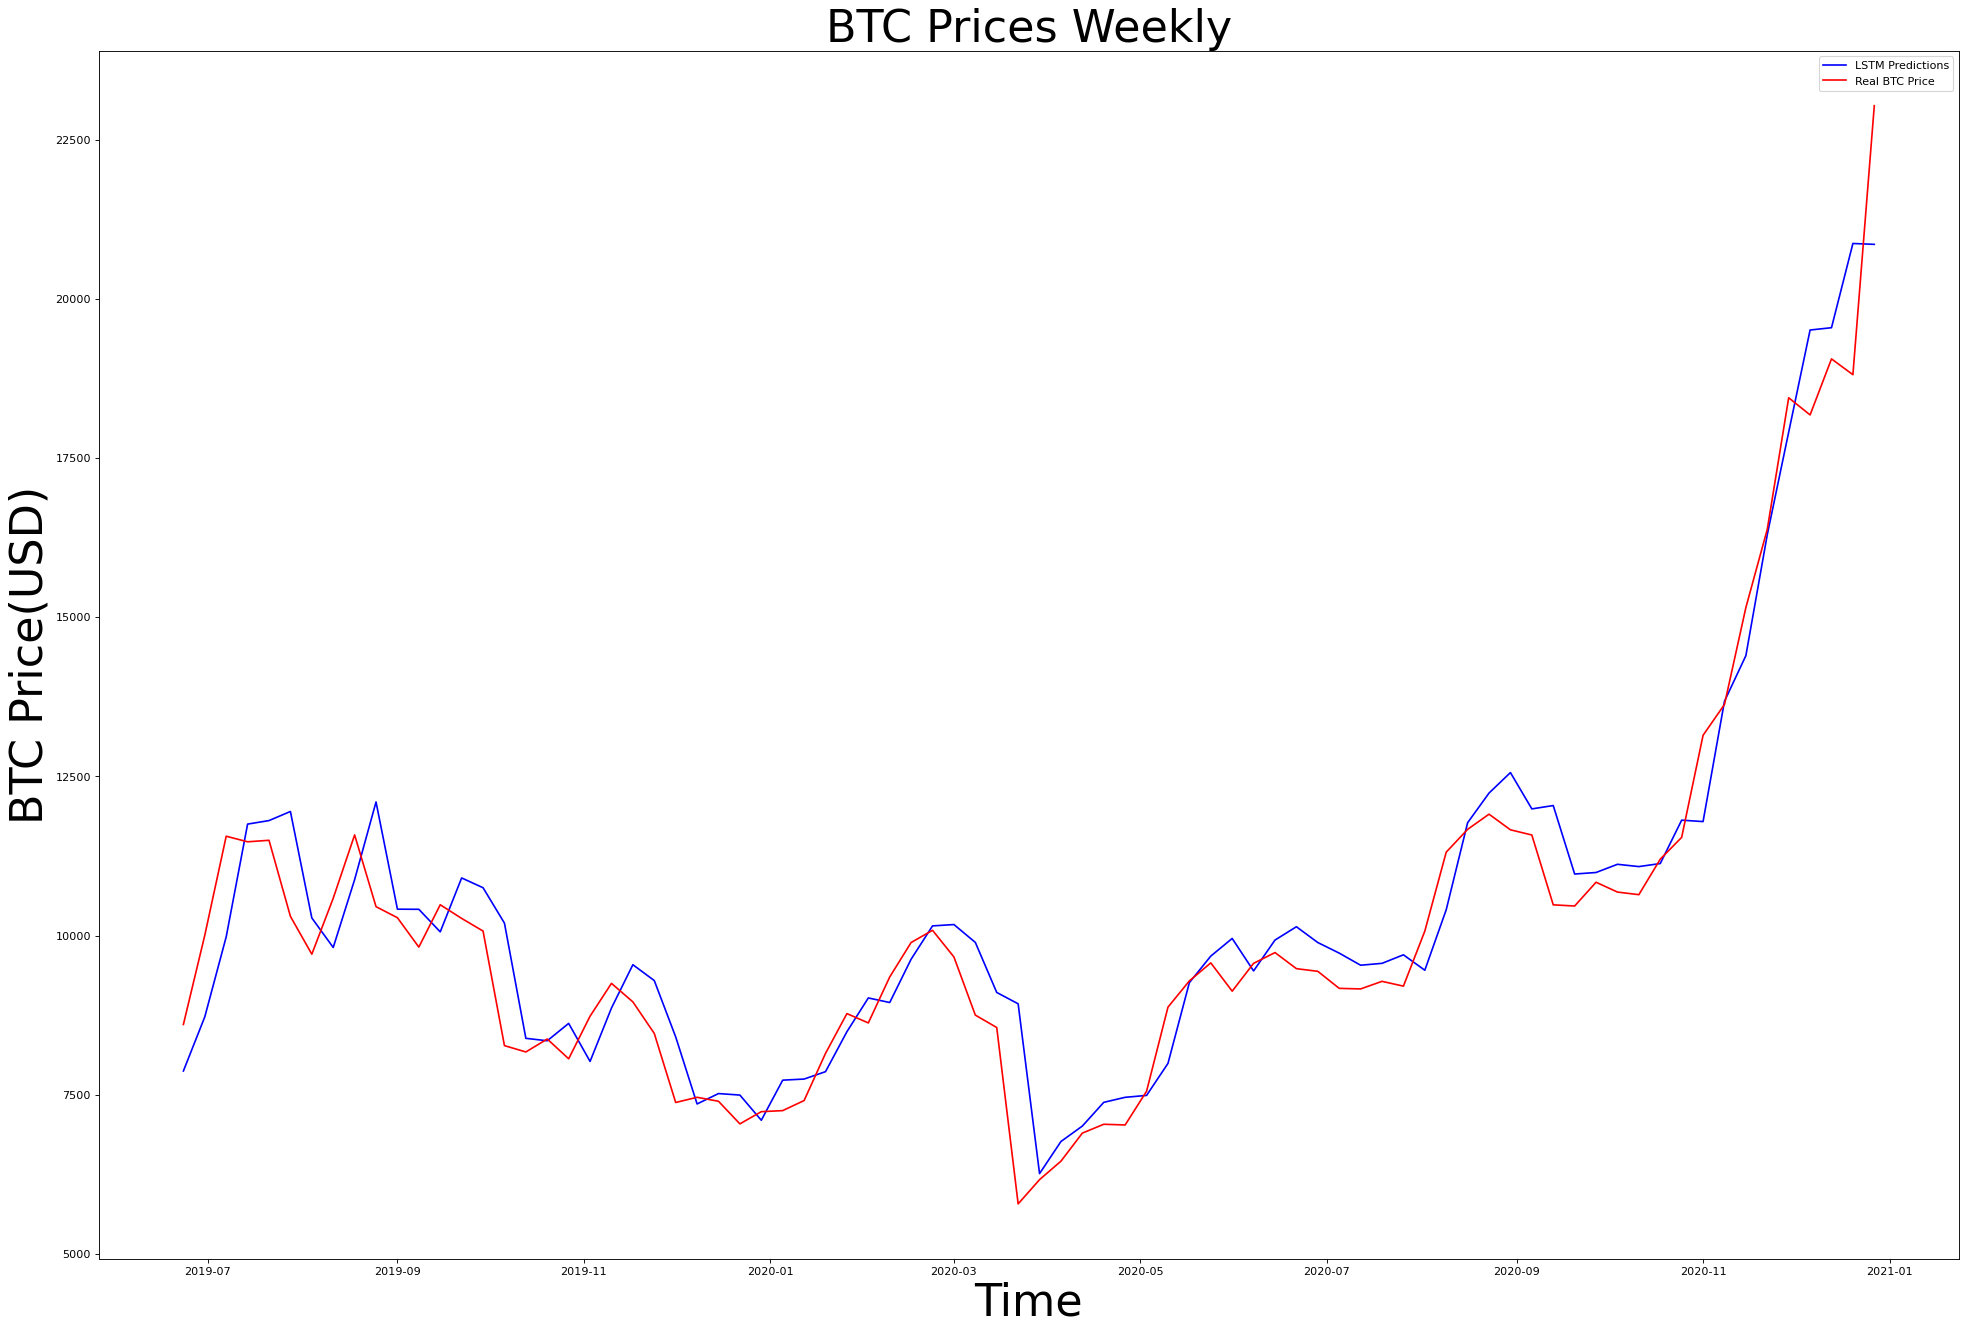

In [62]:
y_test_values = [float(i) for i in y_test]
# The Prices of Bitcoin over time
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test.index,y_test_values, color='red', label='Real BTC Price')
plt.title('BTC Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend()
plt.show()

<ipython-input-63-642bf5ccaf3c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_x['Mean Prices'] = y_train['Mean Prices']


<AxesSubplot:xlabel='Hafta', ylabel='Hafta'>

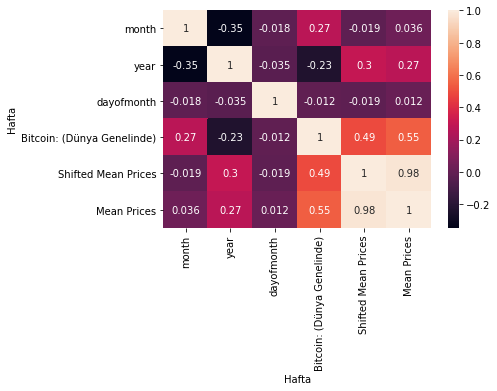

In [63]:
# To see the correlation values
dummy_x = X_train
dummy_x['Mean Prices'] = y_train['Mean Prices']
sns.heatmap(dummy_x.corr(),annot = True)

## Predicting the model with google trends (shifted) as features

In [106]:
min_max_scaler = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()

In [107]:
# Turning input X_Train to appropriate shape for LSTM    ((n_samples, time_steps, features))
x_training_set = X_train_shifted_google.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))
x_training_set

array([[[0.00000000e+00, 0.00000000e+00, 9.33333333e-01, 0.00000000e+00,
         8.87577212e-03]],

       [[9.09090909e-02, 0.00000000e+00, 1.33333333e-01, 0.00000000e+00,
         0.00000000e+00]],

       [[9.09090909e-02, 0.00000000e+00, 3.66666667e-01, 0.00000000e+00,
         7.81734065e-04]],

       [[9.09090909e-02, 0.00000000e+00, 6.00000000e-01, 0.00000000e+00,
         3.46104907e-03]],

       [[9.09090909e-02, 0.00000000e+00, 8.33333333e-01, 0.00000000e+00,
         6.51698470e-03]],

       [[1.81818182e-01, 0.00000000e+00, 1.33333333e-01, 2.35294118e-02,
         1.04300291e-02]],

       [[1.81818182e-01, 0.00000000e+00, 3.66666667e-01, 2.35294118e-02,
         9.84040671e-03]],

       [[1.81818182e-01, 0.00000000e+00, 6.00000000e-01, 1.17647059e-02,
         1.57202588e-02]],

       [[1.81818182e-01, 0.00000000e+00, 8.33333333e-01, 1.17647059e-02,
         2.18778463e-02]],

       [[2.72727273e-01, 0.00000000e+00, 3.33333333e-02, 0.00000000e+00,
         2.2167357

In [108]:
y_train = pd.DataFrame(y_train_shifted_google)
list(y_train['Mean Prices'])
y_train_values = [float(i) for i in y_train['Mean Prices']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y.fit_transform(y_train_values)

In [109]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
25/25 [==============================] - 1s 716us/step - loss: 0.0803
Epoch 2/100
25/25 [==============================] - 0s 737us/step - loss: 0.0259
Epoch 3/100
25/25 [==============================] - 0s 828us/step - loss: 0.0244
Epoch 4/100
25/25 [==============================] - 0s 790us/step - loss: 0.0158
Epoch 5/100
25/25 [==============================] - 0s 768us/step - loss: 0.0166
Epoch 6/100
25/25 [==============================] - 0s 706us/step - loss: 0.0135
Epoch 7/100
25/25 [==============================] - 0s 743us/step - loss: 0.0132
Epoch 8/100
25/25 [==============================] - 0s 721us/step - loss: 0.0069
Epoch 9/100
25/25 [==============================] - 0s 747us/step - loss: 0.0067
Epoch 10/100
25/25 [==============================] - 0s 743us/step - loss: 0.0057
Epoch 11/100
25/25 [==============================] - 0s 696us/step - loss: 0.0049
Epoch 12/100
25/25 [==============================] - 0s 749us/step - loss: 0.0043
Epoch 13/100


25/25 [==============================] - 0s 692us/step - loss: 0.0017
Epoch 100/100
25/25 [==============================] - 0s 737us/step - loss: 0.0014


In [110]:
# Predicting the model with shifted google trends as features
test_set = X_test_shifted_google.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 5))
inputs = min_max_scaler.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 5))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 5))
predicted_price = min_max_scaler_y.inverse_transform(predicted_price)
inputs

array([[[0.45454545, 1.        , 0.73333333, 0.15294118, 0.42921616]],

       [[0.45454545, 1.        , 0.96666667, 0.25882353, 0.47790046]],

       [[0.54545455, 1.        , 0.2       , 0.15294118, 0.56441243]],

       [[0.54545455, 1.        , 0.43333333, 0.14117647, 0.6603604 ]],

       [[0.54545455, 1.        , 0.66666667, 0.14117647, 0.65495388]],

       [[0.54545455, 1.        , 0.9       , 0.09411765, 0.6564207 ]],

       [[0.63636364, 1.        , 0.1       , 0.09411765, 0.58269169]],

       [[0.63636364, 1.        , 0.33333333, 0.11764706, 0.54600806]],

       [[0.63636364, 1.        , 0.56666667, 0.09411765, 0.60025768]],

       [[0.63636364, 1.        , 0.8       , 0.08235294, 0.66161424]],

       [[0.72727273, 1.        , 0.        , 0.41176471, 0.59207922]],

       [[0.72727273, 1.        , 0.23333333, 1.11764706, 0.58135511]],

       [[0.72727273, 1.        , 0.46666667, 0.63529412, 0.552885  ]],

       [[0.72727273, 1.        , 0.7       , 0.56470588, 0.59392

In [111]:
mae_google_trends = mean_absolute_error(y_test,predicted_price)
rmse_google_trends = mean_squared_error(y_test,predicted_price,squared=False)

print("Mean Absolute Error for features including shifted google trends and shifted mean prices and date: ",mae_google_trends)
print("Root Mean Squared Error for features including shifted google trends and shifted mean prices and date: ",rmse_google_trends)

Mean Absolute Error for features including shifted google trends and shifted mean prices and date:  635.629225602476
Root Mean Squared Error for features including shifted google trends and shifted mean prices and date:  916.7608394689012


In [113]:
# Metrics

In [ ]:
'''
Mean Absolute Error for features including google trends and shifted mean prices and date:  617.6004945163918
Root Mean Squared Error for features including google trends and shifted mean prices and date:  835.105946170023


Mean Absolute Error for features shifted mean prices and date:  587.9565441278194
Root Mean Squared Error for features shifted mean prices and date:  815.7367063867564


Mean Absolute Error for features including shifted google trends and shifted mean prices and date:  635.629225602476
Root Mean Squared Error for features including shifted google trends and shifted mean prices and date:  916.7608394689012
'''